# Visualization of CNMF outputs

You must already have a containing CNMF outputs to run this nb

In [1]:
from mesmerize_core import *
import numpy as np
import pandas as pd

2023-01-08 01:31:44.276767: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 01:31:44.359716: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-08 01:31:44.758577: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kushalk/python-venvs/mescore/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib64
2023-01-08 01:31:44.758636: W tensorflow/stream_executor/platform/default/dso_

**You will need `fastplotlib` installed for the visualizations**

In [2]:
from fastplotlib import ImageWidget, Plot, GridPlot
from ipywidgets import VBox, IntSlider, Layout

In [3]:
pd.options.display.max_colwidth = 120

# Paths

In [4]:
# for this demo set this dir as the path to your `caiman_data` dir
set_parent_raw_data_path("/home/kushalk/caiman_data/")

# batch path
batch_path = get_parent_raw_data_path().joinpath("mesmerize-core-batch/batch.pickle")

## Load batch

In [5]:
df = load_batch(batch_path)
df

,algo,item_name,input_movie_path,params,outputs,comments,uuid
0,mcorr,Sue_2x_3000_40_-46,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': (6, 6), 'strides': (24, 24), 'overlaps': (12, 12), 'max_deviation_rigid': 3, 'border_nan': '...",{'mean-projection-path': 09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428_mean_projection.n...,None,09610b86-917a-41e7-a493-2d036bf44428
1,cnmf,Sue_2x_3000_40_-46,09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.85, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (4, 4), 'ssub': 1, 't...",{'mean-projection-path': 2b9dabd8-7d22-4327-8479-aea36bde79cf/2b9dabd8-7d22-4327-8479-aea36bde79cf_mean_projection.n...,None,2b9dabd8-7d22-4327-8479-aea36bde79cf
2,cnmf,Sue_2x_3000_40_-46,09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (6, 6), 'ssub': 1, 'ts...",{'mean-projection-path': 38f85afb-417f-453a-8da5-28753b0dc290/38f85afb-417f-453a-8da5-28753b0dc290_mean_projection.n...,None,38f85afb-417f-453a-8da5-28753b0dc290
3,cnmf,Sue_2x_3000_40_-46,09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (6, 6), 'ssub': 1, 't...",None,None,a49689ad-f093-49ff-9a86-058835eccd34
4,cnmf,Sue_2x_3000_40_-46,09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (6, 6), 'ssub': 1, 'ts...",None,None,f67dbcb9-fd5b-4d81-acc4-f080a7f81db4
5,cnmf,Sue_2x_3000_40_-46,09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (6, 6), 'ssub': 1, 't...",None,None,ff76c624-2c29-4c2d-ba91-3eb471a8e9e3
6,cnmf,Sue_2x_3000_40_-46,09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (8, 8), 'ssub': 1, 'ts...",None,None,879d1d8b-dfe7-4b4f-aa2f-b987d83f7788
7,cnmf,Sue_2x_3000_40_-46,09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (8, 8), 'ssub': 1, 't...",None,None,539745c5-ec3e-4a63-a7c2-eb41af9a080e
8,cnmf,Sue_2x_3000_40_-46,09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (8, 8), 'ssub': 1, 'ts...",None,None,da760704-f760-4f34-b26a-06eb5cc3cfec
9,cnmf,Sue_2x_3000_40_-46,09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (8, 8), 'ssub': 1, 't...",None,None,f4474d42-f6ae-4fba-a1a5-c181b4b1796e


# Load outputs

CNMF pandas extensions API: https://mesmerize-core.readthedocs.io/en/latest/api/cnmf.html 

In [6]:
# You can change this to plot the outputs for different batch items
index = 1

# get the motion corrected input movie as a memmap
cnmf_movie = df.iloc[index].caiman.get_input_movie()

# we can get the contours of the spatial components
contours, coms = df.iloc[index].cnmf.get_contours("all", swap_dim=False)

# and temporal components
temporal = df.iloc[index].cnmf.get_temporal("all")

ixs_good = df.iloc[index].cnmf.get_good_components()
ixs_bad = df.iloc[index].cnmf.get_bad_components()

Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap


# Visualize CNMF outputs. We'll create some simple and more complex plots.

### `ImageWidget` to view contours, and a simple `fastplotlib.Plot` to view temporal components

In [7]:
# LineSlider is very new and experimental and is likely to change
# that's why it's not exposed as a top-level import
from fastplotlib.graphics.line_slider import LineSlider

In [8]:
# for the image data and contours
iw_cnmf = ImageWidget(cnmf_movie, vmin_vmax_sliders=True, cmap="gnuplot2")

# add good contours to the plot within the widget
contours_graphic = iw_cnmf.plot.add_line_collection(contours, colors="cyan", name="contours")
contours_graphic[ixs_good].colors = "cyan"
contours_graphic[ixs_bad].colors = "magenta"


# temporal plot
plot_temporal = Plot()

temporal_graphic = plot_temporal.add_line_collection(temporal, colors="cyan", name="temporal")
temporal_graphic[ixs_good].colors = "cyan"
temporal_graphic[ixs_bad].colors = "magenta"

# a vertical line that is syncronized to the image widget "t" (timepoint) slider
_ls = LineSlider(x_pos=0, bounds=(temporal.min(), temporal.max()), slider=iw_cnmf.sliders["t"])
plot_temporal.add_graphic(_ls)

# stack them
VBox([plot_temporal.show(), iw_cnmf.show()])

RFBOutputContext()

RFBOutputContext()

Auto-scale temporal plot, you can only do this after calling `show()`

In [9]:
plot_temporal.auto_scale()
plot_temporal.camera.scale.x = 0.85

# Interactivity

In [10]:
# don't worry about understanding this function
def euclidean(source, target, event, new_data):
    """maps click events to contour"""
    # calculate coms of line collection
    indices = np.array(event.pick_info["index"])
    
    coms = list()

    for contour in target.items:
        coors = contour.data()[~np.isnan(contour.data()).any(axis=1)]
        com = coors.mean(axis=0)
        coms.append(com)

    # euclidean distance to find closest index of com 
    indices = np.append(indices, [0])
    
    ix = int(np.linalg.norm((coms - indices), axis=1).argsort()[0])
    
    target._set_feature(feature="colors", new_data=new_data, indices=ix)
    
    return None

In [11]:
# so we can view them one by one, first hide all of them
temporal_graphic[:].present = False

image_graphic = iw_cnmf.plot["image"]

# link image to contours
image_graphic.link(
    "click",
    target=contours_graphic,
    feature="colors", 
    new_data="w", 
    callback=euclidean
)

# link contour color changes (which are triggered by the click events as defined above) to everything else

# thickness of contour
contours_graphic.link("colors", target=contours_graphic, feature="thickness", new_data=5)

# toggle temporal component when contour changes color
contours_graphic.link("colors", target=temporal_graphic, feature="present", new_data=True)
# autoscale temporal plot to the current temporal component
temporal_graphic[:].present.add_event_handler(plot_temporal.auto_scale)

/home/kushalk/repos/fastplotlib/fastplotlib/graphics/features/_base.py:87: UserWarning: Event handler <bound method Interaction.event_handler of 'contours' fastplotlib.LineCollection @ 0x7f4d8a60f310> is already registered.
  warn(f"Event handler {handler} is already registered.")


Close canvases if you GPU is slow

In [12]:
plot_temporal.canvas.close()
iw_cnmf.plot.canvas.close()

# View the reconstructed movie, residuals, and reconstructed background

### We can get each of these as a mesmerize `LazyArray` which allows fast visualization of larger-than-RAM arrays that can be computed on the fly.

In [13]:
# reconstructed movie, A * C
rcm = df.iloc[index].cnmf.get_rcm()
rcm

LazyArrayRCM @0x7f4cdc65e9e0
LazyArray for reconstructed movie, i.e. A ⊗ C
Frames are computed only upon indexing
shape [frames, x, y]: (3000, 170, 170)
n_components: 155

### `LazyArray` behaves similar to numpy arrays. But frames are computed only uppon indexing.

In [14]:
rcm[100].shape

(170, 170)

In [15]:
rcm.shape

(3000, 170, 170)

### Get size of the full array in gigabytes if it were entirely stored in RAM. This can be very large for real daa.

In [16]:
rcm.nbytes_gb

0.6936

### Some lazy arrays contain pre-computed min and max for the array, and other useful properties

In [17]:
rcm.max

1720.2145222469883

RFBOutputContext()


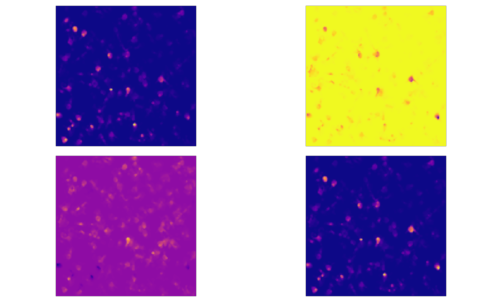

JupyterWgpuCanvas()

In [18]:
gp = GridPlot((2, 2), controllers="sync")

for sp, img in zip(gp, [rcm.max_image, rcm.min_image, rcm.mean_image, rcm.std_image]):
    sp.add_image(img)
    
gp.show()

In [19]:
gp.canvas.close()

# Visualize RCM, RCB and Residuals

In [20]:
rcb = df.iloc[index].cnmf.get_rcb()
residuals = df.iloc[index].cnmf.get_residuals()

iw_cnmf_grid = ImageWidget(
    data=[cnmf_movie, rcm, rcb, residuals],
    vmin_vmax_sliders=True,
    cmap="gnuplot2",
    names=["movie", "A * C", "b * f", "residuals"]
)

for subplot in iw_cnmf_grid.plot:
    subplot.add_line_collection(contours)

contours_graphic[ixs_good].colors = "cyan"
contours_graphic[ixs_bad].colors = "magenta"

iw_cnmf_grid.show()

Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap


RFBOutputContext()

/home/kushalk/repos/mesmerize-core/mesmerize_core/arrays/_cnmf.py:246: UserWarning: min and max not yet implemented for LazyArrayResiduals. Using first frame of raw movie
  warn("min and max not yet implemented for LazyArrayResiduals. "
/home/kushalk/repos/mesmerize-core/mesmerize_core/arrays/_cnmf.py:252: UserWarning: min and max not yet implemented for LazyArrayResiduals. Using first frame of raw movie
  warn("min and max not yet implemented for LazyArrayResiduals. "


### Close the canvas to free up the GPU if necessary 

In [21]:
iw_cnmf_grid.plot.canvas.close()

# Visualize movie, rcm, and stack of temporal components

This example shows only good components, but as shown before you can also compare between good and bad components if you want. You could also use a `GridPlot` or `ImageWidget` to view the contours on top of the residuals and reconstructed background to evaluate if CNMF captured everything.

In [22]:
# 1 row, 3 columns, sync the first 2 subplots plots
cnmf_grid_more = GridPlot((1, 3), controllers=[[0, 0, 1]], names=[["movie", "rcm", "temporal"]])

# movie and rcm, rcm is a lazy array and behaves similar to numpy arrays
movie_graphic = cnmf_grid_more["movie"].add_image(cnmf_movie[0], cmap="gnuplot2")
rcm_graphic = cnmf_grid_more["rcm"].add_image(rcm[0], cmap="gnuplot2")

# contours for good components
contours_good, coms = df.iloc[index].cnmf.get_contours("good", swap_dim=False)

# random colors for contours and temporal components
# make an RGBA array for each color
rand_colors = np.random.rand(len(contours_good), 4)  # [n_contours, RGBA]
rand_colors[:, -1] = 1 # set alpha = 1

# get temporal of only good components
temporal_good = df.iloc[index].cnmf.get_temporal("good")

# add contours to both movie and rcm subplots
contours_movie = cnmf_grid_more["movie"].add_line_collection(contours_good, colors=rand_colors)
contours_rcm = cnmf_grid_more["rcm"].add_line_collection(contours_good, colors=rand_colors)

# line stack of temporal components
temporal_stack = cnmf_grid_more["temporal"].add_line_stack(temporal_good, colors=rand_colors, thickness=3.0, separate=15)

# plot single temporal, just like before
plot_temporal_single = Plot()
temporal_graphic = plot_temporal_single.add_line_collection(temporal_good, colors=rand_colors)

# since this is a GridPlot and not an ImageWidget we need to define sliders
slider = IntSlider(min=0, max=cnmf_movie.shape[0] - 1, value=0, step=1)

# vertical line sliders
_ls = LineSlider(x_pos=0, bounds=(temporal.min(), temporal.max()), slider=slider)
_ls2 = LineSlider(x_pos=0, bounds=(temporal.min(), temporal.max() + temporal_stack.items[-1].position.y), slider=slider)
plot_temporal_single.add_graphic(_ls)
cnmf_grid_more["temporal"].add_graphic(_ls2)

# function to update each frame
def update_frame(change):
    ix = change["new"]
    movie_graphic.data = cnmf_movie[ix]
    rcm_graphic.data = rcm[ix]
    
slider.observe(update_frame, "value")

@plot_temporal_single.renderer.add_event_handler("resize")
def update_slider_width(*args):
    width, h = plot_temporal_single.renderer.logical_size
    slider.layout = Layout(width=f"{width}px")
    
VBox([plot_temporal_single.show(), cnmf_grid_more.show(), slider])

RFBOutputContext()

RFBOutputContext()

### autoscaling

In [23]:
plot_temporal_single.auto_scale()
plot_temporal_single.camera.scale.x = 0.85
cnmf_grid_more["temporal"].auto_scale()

### Interactivity just like before

In [24]:
# so we can view them one by one, first hide all of them
temporal_graphic[:].present = False

# link image to contours
movie_graphic.link(
    "click",
    target=contours_movie,
    feature="colors", 
    new_data="w", 
    callback=euclidean  # we cam re-use it from before
)

# link image to contours
rcm_graphic.link(
    "click",
    target=contours_rcm,
    feature="colors", 
    new_data="w", 
    callback=euclidean  # we cam re-use it from before
)

# contours colors -> contor thickness
contours_movie.link("colors", target=contours_movie, feature="thickness", new_data=5)
contours_rcm.link("colors", target=contours_rcm, feature="thickness", new_data=5)

# contours_movie <-> contours_rcm
contours_rcm.link("colors", target=contours_movie, feature="colors", new_data="w", bidirectional=True)

# temporal stack events
temporal_stack.link("click", target=temporal_stack, feature="colors", new_data="w")
temporal_stack.link("colors", target=temporal_stack, feature="thickness", new_data=4)

# contours <-> temporal stack
contours_movie.link("colors", target=temporal_stack, feature="colors", new_data="w", bidirectional=True)

# temporal stack -> temporal single
temporal_stack.link("colors", target=temporal_graphic, feature="present", new_data=True)

# autoscale temporal plot to the current temporal component
temporal_graphic[:].present.add_event_handler(plot_temporal_single.auto_scale)

/home/kushalk/repos/fastplotlib/fastplotlib/graphics/features/_base.py:87: UserWarning: Event handler <bound method Interaction.event_handler of fastplotlib.LineCollection @ 0x7f4cdc1d2950> is already registered.
  warn(f"Event handler {handler} is already registered.")
/home/kushalk/repos/fastplotlib/fastplotlib/graphics/features/_base.py:87: UserWarning: Event handler <bound method Interaction.event_handler of fastplotlib.LineCollection @ 0x7f4cdc29c310> is already registered.
  warn(f"Event handler {handler} is already registered.")
/home/kushalk/repos/fastplotlib/fastplotlib/graphics/features/_base.py:87: UserWarning: Event handler <bound method Interaction.event_handler of fastplotlib.LineStack @ 0x7f4cc60063e0> is already registered.
  warn(f"Event handler {handler} is already registered.")


In [25]:
plot_temporal_single.canvas.close()
cnmf_grid_more.canvas.close()